In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout, Activation, GRU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import f1_score

In [25]:
train_data = pd.read_csv('Train_DataSet.csv')
train_label = pd.read_csv('Train_DataSet_Label.csv')
train = pd.merge(train_data, train_label, how='left', on='id')
train = train[(train.label.notnull()) & (train.content.notnull())]
test = pd.read_csv('Test_DataSet.csv')

train['title'] = train['title'].fillna('')
train['content'] = train['content'].fillna('')
test['title'] = test['title'].fillna('')
test['content'] = test['content'].fillna('')

In [26]:
import re
def filter(text):
    text = re.sub("[A-Za-z0-9\!\=\？\%\[\]\,\（\）\>\<:&lt;\/#\. -----\_]", "", text)
    text = text.replace('图片', '')
    text = text.replace('\xa0', '') # 删除nbsp
    # new
    r1 =  "\\【.*?】+|\\《.*?》+|\\#.*?#+|[.!/_,$&%^*()<>+""'?@|:~{}#]+|[——！\\\，。=？、：“”‘’￥……（）《》【】]"
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, ' ', text)        #去除html标签
    text = re.sub(r1,'',text)
    text = text.strip()
    return text


In [27]:
def clean_text(data):
    data['title'] = data['title'].apply(lambda x: filter(x))
    data['content'] = data['content'].apply(lambda x: filter(x))
    return data
train = clean_text(train)
test = clean_text(test)

In [28]:
stop_words = pd.read_table('stop.txt', header=None)[0].tolist()

In [29]:
import jieba
import string
table = str.maketrans("","",string.punctuation)
def cut_text(sentence):
    tokens = list(jieba.cut(sentence))
    # 去除停用词
    tokens = [token for token in tokens if token not in stop_words]
#     # 去除英文标点
#     tokens = [w.translate(table) for w in tokens]
    return tokens

In [30]:
train_title = [cut_text(sent) for sent in train.title.values]
train_content = [cut_text(sent) for sent in train.content.values]
test_title = [cut_text(sent) for sent in test.title.values]
test_content = [cut_text(sent) for sent in test.content.values]

In [86]:
train_title

[['问责', '领导', '上', '黄镇', '党委书记', '张涛', '宣国', '才', '真能', '一手遮天'],
 ['江歌', '事件', '教会', '孩子', '善良', '更要', '懂得', '保护'],
 ['绝味', '鸭', '脖', '广告', '开', '黄腔', '引', '众怒', '双', '拼值'],
 ['央视', '曝光', '如东', '医药企业', '槽罐车', '改成', '垃圾车', '夜间', '偷排', '高浓度', '废水'],
 ['恶劣',
  '至极',
  '央视',
  '都',
  '曝光',
  '南通',
  '如东',
  '医药企业',
  '槽罐车',
  '改成',
  '洒水车',
  '夜间',
  '偷排',
  '高浓度',
  '废水',
  '丢',
  '大发'],
 ['央视', '曝光', '南通', '医药企业', '夜间', '偷排', '高浓度', '废水', '丢脸'],
 ['粉丝', '爆料', '五洲', '国际', '无锡', '项目', '涉嫌', '诈骗', '非法', '集资'],
 ['年内', '约', '锂电', '重组', '失败', '资本', '高', '估值', '收购', '说', '不'],
 ['男子', '梦想', '一夜', '暴富', '持', '水泥块', '砸机'],
 ['北京', '多家', '法院', '供暖', '纠纷案件', '主体', '供暖费', '追缴', '山海', '网'],
 ['手机号', '开头', '注意', '看', '完', '冷汗', '都', '出来', '搜', '搜狐'],
 ['网红', '土坯房', '书记', '落马', '背后'],
 ['曾经', '品质', '烤肉', '两年', '难吃'],
 ['土俄',
  '军火交易',
  '再起',
  '波折',
  '鱼熊',
  '无法',
  '兼顾',
  '土',
  '成美',
  '俄',
  '交锋',
  '牺牲品',
  '搜狐',
  '军事',
  '搜狐网'],
 ['闲鱼', '网上交易', '平台', '购买', '代付款', '服务', '我要', '国外', '网站', '上', 

In [31]:
all_doc = train_title + train_content + test_title + test_content

In [32]:
import gensim
import time
class EpochSaver(gensim.models.callbacks.CallbackAny2Vec):
    '''用于保存模型, 打印损失函数等等'''
    def __init__(self, save_path):
        self.save_path = save_path
        self.epoch = 0
        self.pre_loss = 0
        self.best_loss = 999999999.9
        self.since = time.time()

    def on_epoch_end(self, model):
        self.epoch += 1
        cum_loss = model.get_latest_training_loss() # 返回的是从第一个epoch累计的
        epoch_loss = cum_loss - self.pre_loss
        time_taken = time.time() - self.since
        print("Epoch %d, loss: %.2f, time: %dmin %ds" % 
                    (self.epoch, epoch_loss, time_taken//60, time_taken%60))
        if self.best_loss > epoch_loss:
            self.best_loss = epoch_loss
            print("Better model. Best loss: %.2f" % self.best_loss)
            model.save(self.save_path)
            print("Model %s save done!" % self.save_path)

        self.pre_loss = cum_loss
        self.since = time.time()
# model_word2vec = gensim.models.Word2Vec.load('final_word2vec_model')

In [33]:
model_word2vec = gensim.models.Word2Vec(min_count=1, 
                                        window=5, 
                                        vector_size=256,
                                        workers=4,
                                        batch_words=1000)
since = time.time()
model_word2vec.build_vocab(all_doc, progress_per=2000)
time_elapsed = time.time() - since
print('Time to build vocab: {:.0f}min {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Time to build vocab: 0min 5s


In [34]:
since = time.time()
model_word2vec.train(all_doc, total_examples=model_word2vec.corpus_count, 
                        epochs=5, compute_loss=True, report_delay=60*10,
                        callbacks=[EpochSaver('./final_word2vec_model')])
time_elapsed = time.time() - since
print('Time to train: {:.0f}min {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print(all_doc)

Epoch 1, loss: 3990903.75, time: 0min 6s
Better model. Best loss: 3990903.75
Model ./final_word2vec_model save done!
Epoch 2, loss: 2667666.75, time: 0min 7s
Better model. Best loss: 2667666.75
Model ./final_word2vec_model save done!
Epoch 3, loss: 2169907.50, time: 0min 9s
Better model. Best loss: 2169907.50
Model ./final_word2vec_model save done!
Epoch 4, loss: 1883296.00, time: 0min 6s
Better model. Best loss: 1883296.00
Model ./final_word2vec_model save done!
Epoch 5, loss: 1787894.00, time: 0min 7s
Better model. Best loss: 1787894.00


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_title)
# tokenizer.fit_on_texts(train_content + test_content)

In [36]:
# 转化成词向量矩阵，利用新的word2vec模型
vocab_size = len(tokenizer.word_index)
error_count=0
embedding_matrix = np.zeros((vocab_size + 1, 256))
for word, i in tqdm(tokenizer.word_index.items()):
    if word in  model_word2vec.wv:
        embedding_matrix[i] = model_word2vec.wv[word]
    else:
        error_count += 1

100%|████████████████████████████████████████████████████████████████████████| 21033/21033 [00:00<00:00, 331327.00it/s]


In [38]:
sequence = tokenizer.texts_to_sequences(train_title)
traintitle = pad_sequences(sequence, maxlen=30)
sequence = tokenizer.texts_to_sequences(test_title)
testtitle = pad_sequences(sequence, maxlen=30)
# sequence = tokenizer.texts_to_sequences(train_content)
# traincontent = pad_sequences(sequence, maxlen=512)
# sequence = tokenizer.texts_to_sequences(test_content)
# testcontent = pad_sequences(sequence, maxlen=512)

In [87]:
from keras import Input, Model
from keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout
class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=1,
                 last_activation='sigmoid'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))

        # Embedding part can try multichannel as same as origin paper
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen,
                              weights=[embedding_matrix])(input)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model
    
model = TextCNN(maxlen=50, max_features=len(tokenizer.word_index) + 1,
                    embedding_dims=256, class_num=3, last_activation='softmax').get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [88]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 50, 256)      5384704     ['input_5[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 48, 128)      98432       ['embedding_7[0][0]']            
                                                                                                  
 conv1d_13 (Conv1D)             (None, 47, 128)      131200      ['embedding_7[0][0]']            
                                                                                            

In [80]:
import keras
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=256, 
                    input_length=30, 
                    weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.35))
model.add(Dense(3, activation='softmax'))
optimizer = keras.optimizers.adam_v2.Adam(lr=0.005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 256)           5384704   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 33        
                                                                 
Total params: 5,550,379
Trainable params: 5,550,379
Non-trainable params: 0
____________________________________________

D:\Anaconda\envs\tensorflow\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [81]:
label = train['label'].astype(int)
# labels = to_categorical(label) 
# train_X, val_X, train_Y, val_Y = train_test_split(traintitle, label, shuffle=True, test_size=0.2,
#                                                     random_state=2019)
train_X, val_X, train_Y, val_Y = train_test_split(traintitle, label, shuffle=True, test_size=0.2,
                                                    random_state=2019)
val_y=val_Y
train_Y = to_categorical(train_Y)
val_Y=to_categorical(val_Y)

In [82]:
model.summary()
history = model.fit(train_X, train_Y, batch_size=128, epochs=10, 
                    verbose=True, validation_data=(val_X, val_Y))
 
#----------------------------------预测与可视化------------------------------
#预测
score = model.evaluate(val_X,val_Y, batch_size=32)
print('test loss:', score[0])
print('test accuracy:', score[1])
# model.fit(traintitle,
#           labels,
#           batch_size=128,
#           epochs=3,
#           shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 256)           5384704   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 33        
                                                                 
Total params: 5,550,379
Trainable params: 5,550,379
Non-trainable params: 0
____________________________________________

In [83]:
pre_y=np.argmax(model.predict(val_X),axis=1)
val_Y=val_y

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
test_accracy = accuracy_score(val_Y,pre_y)
F1_score=f1_score(val_Y,pre_y,average='macro')
Recall_score=recall_score(val_Y,pre_y,average='macro')
Precision_score=precision_score(val_Y,pre_y,average='macro')
print("Accuracy:",test_accracy)
print("Precision_score:",Precision_score)
print("Recall_score:",Recall_score)
print("F1_score:",F1_score)

Accuracy: 0.7455295735900963
Precision_score: 0.6587389826919066
Recall_score: 0.6312946982256206
F1_score: 0.6414120047760323


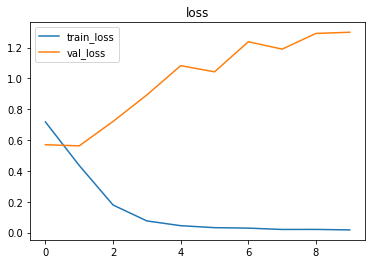

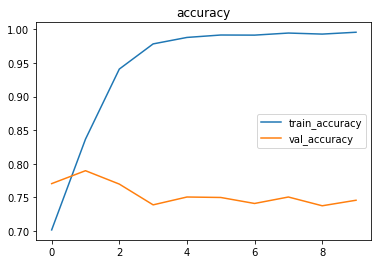

In [85]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [56]:
preds = np.argmax(model.predict(testtitle), axis=1)
test['label'] = preds

In [57]:
test['label'].value_counts()

1    4097
2    2783
0     476
Name: label, dtype: int64

In [58]:
test[test.label==0]

,id,title,content,label
4,0014cef5ccfa43b3a6b20162a03763fa,公安部侦破一批重大网络赌博案件德州约局平台成重灾区,年月公安部指挥河南北京广西等地公安机关联合行动成功侦破北京联众公司棋牌事业部利用网游平台开设...,0
26,00a9e3be90544e748c117ff8e364369e,援疆大爱洒边陲不负重托续华章,辽宁与塔城因为对口援疆工作结下深厚情谊一批接一批的援疆干部在塔城大地持续接力第五批名援疆干部...,0
31,00fa4c4c1fac42a3ac758b02266dc97e,太彪了潍坊这俩女的当街对民警破口大骂结果,点潍坊早读免费关注,0
44,016120c239f547ea8881ab632ddd03bb,沙湾职中代表队斩获全市中学生防震减灾知识竞赛高中组头筹,沙湾新闻网讯雷小军月日在市教育局和市防震减灾局共同主办的全市中学生防震减灾知识竞赛中沙湾职中...,0
59,01e0b7945b6f42658a871bb9b902796a,俄莫斯科一座家具厂着火过火面积达平方米,中新网月日电据俄罗斯卫星网报道俄罗斯紧急情况部莫斯科州总局代表表示莫斯科州晓尔科沃地区一家家...,0
...,...,...,...,...
7292,fdc5e1d13e7c460698cf19516dfd3bfa,铜川市耀州区档案局年部门决算及三公经费支出情况,一部门概况一区档案局机构设置情况铜川市耀州区档案馆局为区委直属事业机构一套编制两块牌子科级建...,0
7307,fe4beab96132456e90a1a31588291bec,利用前庭后院的微田园打造一户一景一村一品的宜居环搜狐,原标题利用前庭后院的微田园打造一户一景一村一品的宜居环境一茬茬韭菜一棵棵嫩葱一株株萝卜菜在安...,0
7316,fe9bbce72c194aea90016898e7ef4c82,福建警方摧毁一个网络水军团伙炒作舆情余起,新华社福州月日电记者王成据福建省公安厅消息莆田警方侦破一起公安部挂牌督办的网络水军案件摧毁网...,0
7322,feda657956884a8691e9fbbbf0cdd946,汕头黑村官二十多年屹立不倒聚美资讯,李廷炎自担任汕头市潮南区成田镇简朴村乡居委会书记以来至今为止已长达二十多年二十多年来披着村书...,0


In [59]:
test[['id', 'label']].to_csv('Bi-LSTM.csv', index=False)
